# Feature Engineering using Keras Lambda Layers for complete training pipeline.

Often for structured data problems we end up using multiple libraries for preprocessing or feature engineering. We can go as far as having a full ML training pipeline using different libraries for example Pandas for reading data and also feature engineeering, sklearn for encoding features for example OneHot encoding and Normalization. The estimator might be an sklearn classifier, xgboost or it can for example be a Keras model. In the latter case, we would end up with artifacts for feature engineering and encoding and also different artifacts for the saved model. The pipeline is also disconnected and an extra step is needed to feed encoded data to the Keras model. For this step the data can be mapped from a dataframe to something like tf.data.Datasets type or numpy array before feeding it to a Keras model.

In this post we will consider implementing a training pipeline natively with Keras/Tensorflow. From loading data with tf.data. As the the title suggested we will use Lambda layers for feature engineering. These engineered features will be stateless. For stateful preprocessing we could use something like Keras preprocessing layers. We will end up with a training pipeline where feature engineering will be part of the network architecture and can be persisted and loaded for inference as standalone.

Keep in mind that tf.keras.layers.Lambda layers have (de)serialization limitations because Lambda layers are saved by serializing the python bytecode.

Steps we will follow:
- Load data with tf.data
- Create Input layer
- Create feature layer using Lambda layers
- Train model

# Example

For the example below we will use the heart disease dataset. Lets import tensorflow and read in the data:

In [2]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [3]:
heart_dir = tf.keras.utils.get_file(
    "heart.csv", origin="http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
)

dataset = tf.data.experimental.make_csv_dataset(
      heart_dir,
      batch_size=64,
      label_name='target',
      num_epochs=10
)

In [4]:
binary_features = ['sex', 'fbs', 'exang']
numeric_features =  ['trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'cp', 'restecg', 'ca']
categoric_features = ['thal']

dtype_mapper = {
        'age': tf.float32,
        'sex': tf.float32,
        'cp': tf.float32,
        'trestbps': tf.float32,
        'chol': tf.float32,
        'fbs': tf.float32,
        'restecg': tf.float32,
        'thalach': tf.float32,
        'exang': tf.float32,
        'oldpeak': tf.float32,
        'slope': tf.float32,
        'ca': tf.float32,
        'thal': tf.string
}


## Create Input Layer

In [5]:
def create_inputs(data_type_mapper):
    """Create model inputs
    Args:
        data_type_mapper (dict): Dictionary with feature as key and dtype as value
                                 For example {'age': tf.float32, ...}
    Returns:
        (dict): Keras inputs for each feature
    """
    return {feature: tf.keras.Input(shape=(1,), name=feature, dtype=dtype)\
        for feature, dtype in data_type_mapper.items()}

feature_layer_inputs = create_inputs(dtype_mapper)

In [6]:
feature_layer_inputs['age']

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>

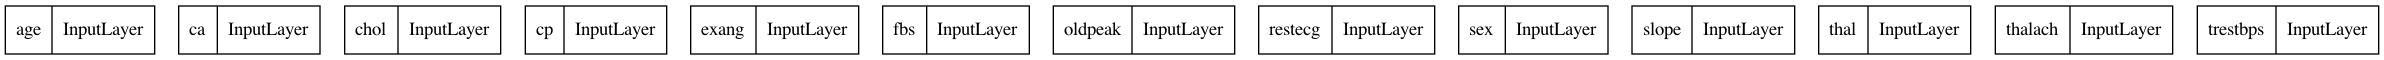

In [7]:
input_layer_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=feature_layer_inputs)
plot_model(input_layer_graph, to_file="input_layer.png")

In [19]:
class FeatureLayer(tf.keras.layers.Layer):
    def __init__(self, func=None, *args, **kwargs):
        super(FeatureLayer, self).__init__(trainable=False, *args, **kwargs)
        if not callable(func):
            raise("function should be callable")
        self.func = func
    
    def call(self, inputs):
        return self.func(inputs[0], inputs[1])

def age_and_gender(age, gender):
  """check if age gt 50 and if gender is male"""
  return tf.cast(
    tf.math.logical_and(age > 50, gender == 1), dtype = tf.float32
  )

age_gender_layer = FeatureLayer(age_and_gender, name='age_and_gender')(
    [feature_layer_inputs['age'], feature_layer_inputs['sex']]
)
submodel = tf.keras.Model(inputs=feature_layer_inputs, outputs=age_gender_layer)
submodel.predict(dataset)

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

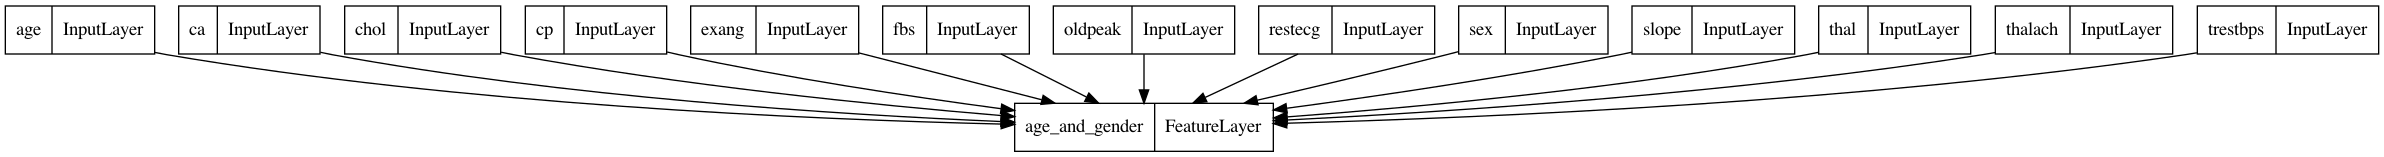

In [12]:
class AgeAndGenderFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(FeatureLayer, self).__init__(trainable=False, *args, **kwargs)
    
    def call(self, inputs):
        thal_is_fixed = tf.cast(inputs['thal'] == 'fixed', dtype = tf.float32)
        age_and_gender = tf.cast(
            tf.math.logical_and(inputs['age'] > 50, inputs['sex'] == 1), dtype = tf.float32
        )
        return tf.keras.layers.concatenate([age_and_gender, thal_is_fixed])
    
    
feature_layer = FeatureLayer(name='age_and_gender')(feature_layer_inputs)

feature_layer_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=feature_layer)
plot_model(feature_layer_graph, to_file="feature_layer_graph.png")

## Engineered Features: Custom functions for Lambda Layers

In [95]:
# Define functions for engineered features


def square(x):
  """apply sqaure of feature"""
  return x ** 2


def ratio(x):
  """compute the ratio between two numeric features"""
  return x[0] / x[1]


def cross_feature(x):
  """compute the crossing of two features"""
  return tf.cast(x[0] * x[1], dtype = tf.float32)


def age_and_gender(x):
  """check if age gt 50 and if gender is male"""
  return tf.cast(
    tf.math.logical_and(x[0] > 50, x[1] == 1), dtype = tf.float32
  )


# Similar to One-hot-Encoding
def is_fixed(x):
  """encode categoric feature if value is equal to fixed"""
  return tf.cast(x == 'fixed', dtype = tf.float32)


def is_reversible(x):
  """encode categoric feature if value is equal to fixed"""
  return tf.cast(x == 'reversible', dtype = tf.float32)


def is_normal(x):
  """encode categoric feature if value is equal to fixed"""
  return tf.cast(x == 'normal', dtype = tf.float32)

### Now that we have our custom functions lets create the features as Lambda layers:

In [96]:
# The features based on thal is similar to one-hot encoding. 
# Here we only illustrate using lambda layers

is_fixed = tf.keras.layers.Lambda(is_fixed, name='is_fixed')(
   feature_layer_inputs['thal']
)

is_normal = tf.keras.layers.Lambda(is_normal, name='is_normal')(
   feature_layer_inputs['thal']
)

is_reversible = tf.keras.layers.Lambda(is_reversible, name='is_reversible')(
   feature_layer_inputs['thal']
)

age_and_gender = tf.keras.layers.Lambda(age_and_gender, name='age_and_gender')(
    (feature_layer_inputs['age'], feature_layer_inputs['sex'])
)

# example using python lambda function
age = tf.keras.layers.Lambda(lambda x: tf.cast(x > 60, dtype = tf.float32), name='age_gt_50')(
    feature_layer_inputs['age']
)

trest_chol_ratio = tf.keras.layers.Lambda(ratio, name='trest_chol_ratio')(
   (feature_layer_inputs['trestbps'], feature_layer_inputs['chol'])
)

trest_cross_thalach = tf.keras.layers.Lambda(cross_feature, name='trest_cross_thalach')(
   (feature_layer_inputs['trestbps'], feature_layer_inputs['thalach'])
)

# concat all newly created features into one layer
feature_list = [is_fixed, is_normal, is_reversible, age, 
                age_and_gender, trest_chol_ratio, trest_cross_thalach]

lambda_feature_layer = tf.keras.layers.concatenate(feature_list, name='lambda_feature_layer')

# Visualize Lambda feature Layer

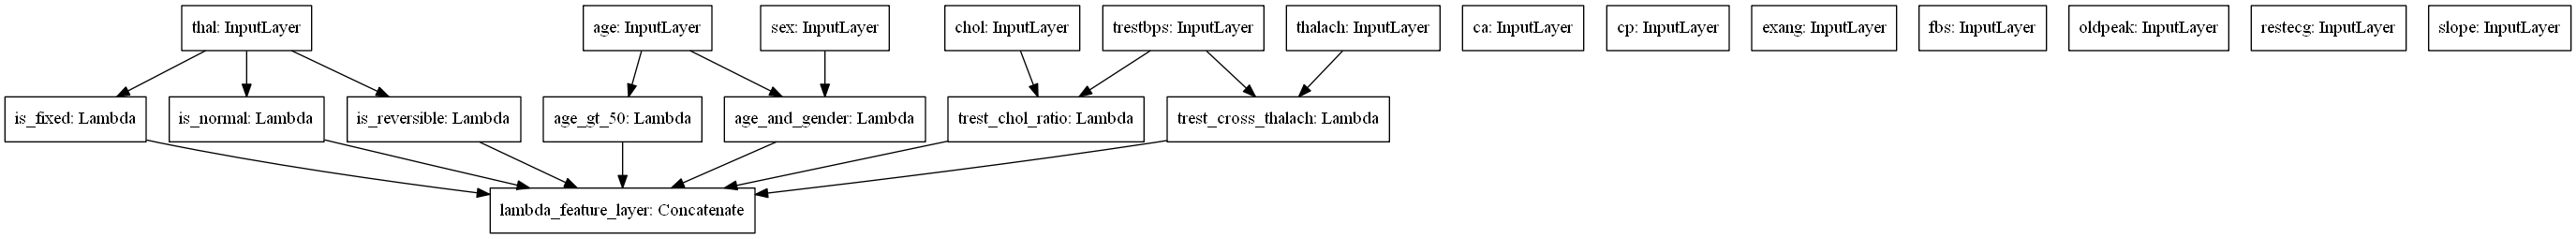

In [97]:
feature_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=lambda_feature_layer)
plot_model(feature_graph, to_file="lambda_feature_layer.png")

## All our engineered feature layers are created and we can now combine it with our other features

In [98]:
numeric_feature_layer = tf.keras.layers.concatenate(
    [feature_layer_inputs[feature] for feature in numeric_features], name='numeric_feature_layer'
)

binary_feature_layer = tf.keras.layers.concatenate(
    [feature_layer_inputs[feature] for feature in binary_features], name='binary_feature_layer'
)

# Add the rest of features
feature_layer = tf.keras.layers.concatenate(
    [lambda_feature_layer, numeric_feature_layer, binary_feature_layer], name='feature_layer'
)

# Visualize full Feature Layer

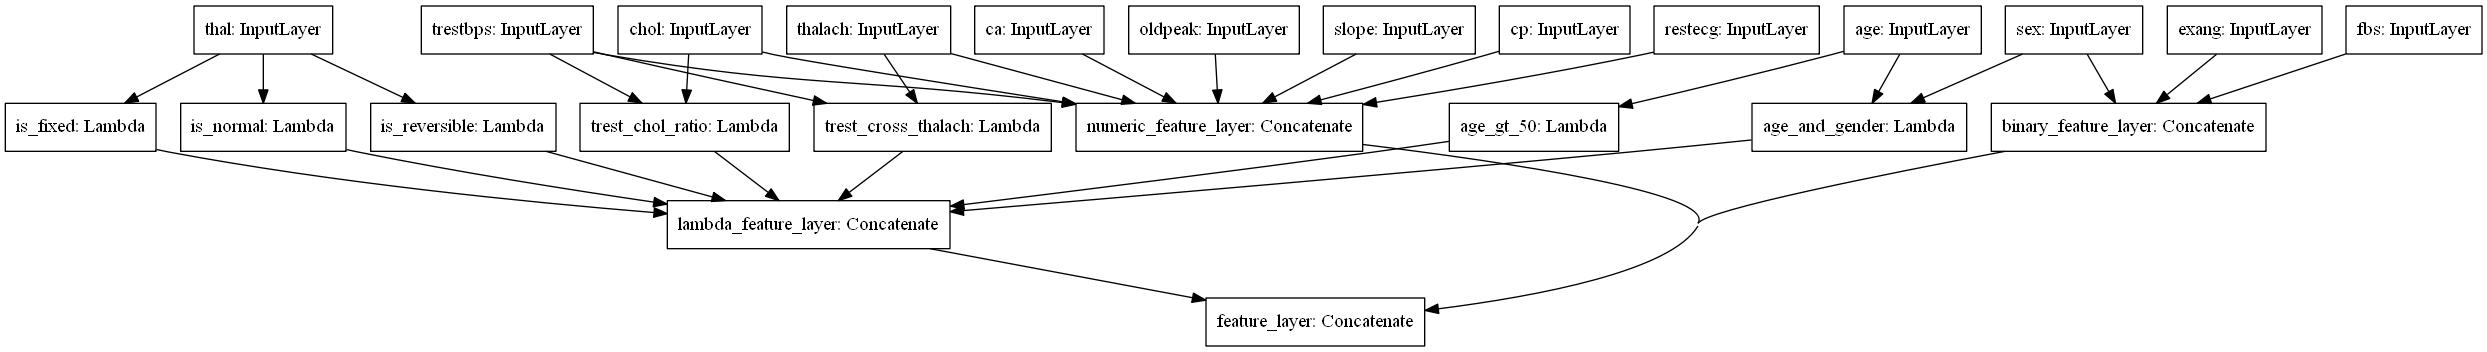

In [99]:
full_feature_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=feature_layer)
plot_model(full_feature_graph, to_file="complete_feature_layer.png")

## Our last step is to create and fit our Keras model. For this example we will use a simple model architecture. We will persist the model and load it for inference.

In [100]:
# setup model, this is basically Logistic regression
x = tf.keras.layers.BatchNormalization(name='batch_norm')(feature_layer)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='target')(x)
model = tf.keras.Model(inputs=feature_layer_inputs, outputs=output)
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
           tf.keras.metrics.AUC(name='auc')]
)

# Visualize full network

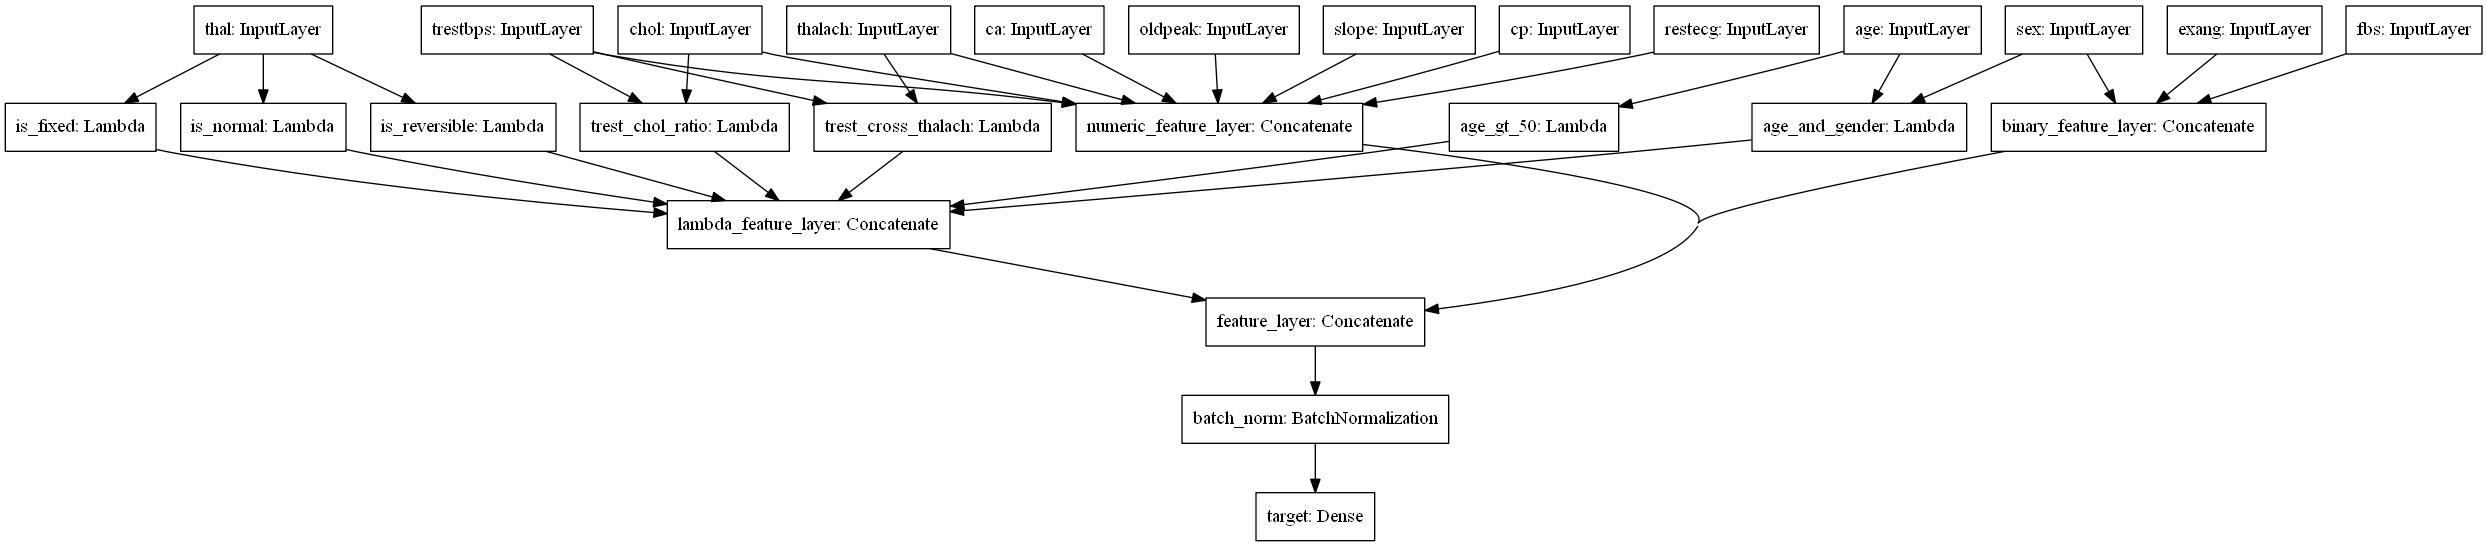

In [101]:
plot_model(model, to_file="full_model.png")

# Train Model and Save model

In [102]:
model.fit(dataset, epochs=10)

# save model
tf.keras.models.save_model(model, "lambda_layered_model")

Epoch 1/10
48/48 [==============================] - 1s 3ms/step - loss: 0.3848 - accuracy: 0.8370 - auc: 0.8936
Epoch 2/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8647 - auc: 0.9290
Epoch 3/10
48/48 [==============================] - 0s 3ms/step - loss: 0.3025 - accuracy: 0.8690 - auc: 0.9317
Epoch 4/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3061 - accuracy: 0.8690 - auc: 0.9288
Epoch 5/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 0.8673 - auc: 0.9310
Epoch 6/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3040 - accuracy: 0.8650 - auc: 0.9304
Epoch 7/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3024 - accuracy: 0.8660 - auc: 0.9313
Epoch 8/10
48/48 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.8686 - auc: 0.9318
Epoch 9/10
48/48 [==============================] - 0s 3ms/step - loss: 0.3020 - accuracy: 0.8644 - auc:

# Load model and predict on raw data

In [103]:
# load model for inference
loaded_model = tf.keras.models.load_model("lambda_layered_model")

In [104]:
dict(zip(loaded_model.metrics_names, loaded_model.evaluate(dataset)))

48/48 [==============================] - 0s 3ms/step - loss: 0.2970 - accuracy: 0.8713 - auc: 0.9340


{'loss': 0.2970246374607086,
 'accuracy': 0.8712871074676514,
 'auc': 0.934036135673523}